In [1]:
### CONTINUUM DATA OBSERVATION

In [2]:
### DEFINING EXTRACTION UNIVERSE DATA FROM GENERAL MS EXCEL SOURCE
def get_market_membership_from_excel(path_msci):
    ### Importing standard modules and date-special modules:
    import numpy as np
    import pandas as pd
    ### Declaring local constants & variables: 
    tab_monthly = 'universe_joined'    
    arr_markets_needed = ['DM', 'FM', 'EM']   
    dict_markets = {50 : 'DM', 57 : 'EM', 504 : 'FM'}
    no_slice = slice(None)
    ### Extracting universe data:
    df_universe = pd.read_excel(io = path_msci, sheet_name = tab_monthly, skiprows = [0, 2], header = 0, parse_dates = True, 
                                na_values = ['', '#N/A', '#N/A N/A', '#NA', '-1.#IND', '-1.#QNAN', '-NaN', '-nan', '1.#IND', 
                                             '1.#QNAN', 'N/A', 'NULL', 'NaN', 'n/a', 'nan', 'null'], keep_default_na = False)
    df_universe = df_universe.loc[no_slice, ['dates', 'region', 'ctry']]
    df_universe.columns = ['Date', 'Market', 'Country']
    df_universe.set_index(['Date', 'Country'], inplace = True)
    ser_universe = df_universe.squeeze()
    ser_universe.sort_index(level = [0, 1], inplace = True)
    ser_universe.replace(dict_markets, inplace = True)
    ser_market_membership = ser_universe[ser_universe.isin(arr_markets_needed)]
    
    return ser_market_membership

In [3]:
### DEFINING EXTRACTION CONTINUUM-PRODUCED DATA FROM MS EXCEL SOURCE
def get_observation_data(path_source, path_msci, flag_stacked = True):
    ### Importing standard modules and date-special modules:
    import numpy as np
    import pandas as pd
    ### Loading data:
    df_politics = pd.read_excel(path_source, index_col = [0, 5, 6], parse_dates = True, 
                                na_values = ['', '#N/A', '#N/A N/A', '#NA', '-1.#IND', '-1.#QNAN', '-NaN', '-nan', '1.#IND', 
                                             '1.#QNAN', 'N/A', 'NULL', 'NaN', 'n/a', 'nan', 'null'], keep_default_na = False)
    ### Mungling table:
    df_politics = df_politics.iloc[: , 12 : ].stack().to_frame()
    df_politics.index.names = ['Country', 'Indicator', 'Group', 'Date_Q']
    df_politics.reset_index('Date_Q', inplace = True)    
    ### Date manipulating:
    df_politics['Date'] = pd.to_datetime(df_politics['Date_Q']) + pd.offsets.BQuarterEnd()
    df_politics.set_index('Date', append = True, inplace = True)
    df_politics.drop('Date_Q', axis = 1, inplace = True)    
    df_politics = df_politics.groupby(['Country', 'Indicator', 'Group']).\
        apply(lambda iter_group: iter_group.droplevel([0, 1, 2]).resample('BM').bfill())
    df_politics = df_politics.reorder_levels(['Date', 'Country', 'Indicator', 'Group'])
    df_politics.columns = ['Value']
    ### Market membership importing:
    ser_market_membership = get_market_membership_from_excel(path_msci)
    ### Adding membership column to result dataframe:    
    df_politics = df_politics.join(ser_market_membership, on = ['Date', 'Country'], how = 'left')
    df_politics = df_politics.set_index('Market', drop = True, append = True)    
    ### Dropping countries with no participation in ISON universe:
    ser_politics = df_politics.loc[(All, ser_market_membership.index.get_level_values(1).unique().to_list(), All), All].squeeze()
    ### Dropping group index and formatting table:
    ser_politics.reset_index('Group', drop = True, inplace = True)
    if (not flag_stacked):
        df_result = ser_politics.unstack('Indicator').sort_index(level = ['Country', 'Date'])
    else:
        df_result = ser_politics
    
    return df_result

In [4]:
### MAIN SCRIPT
### Importing standard modules and date-special modules:
import numpy as np
import pandas as pd
### Declaring global constants & variables: 
path_msci = 'Data_Files/Source_Files/sample_universe.xlsx' ### Path for membership source
#path_composite_indicators = 'Data_Files/Source_Files/OD_Composite_Indicators.xlsx' ### Path for Composite Indicators
#path_growth_potential = 'Data_Files/Source_Files/OD_Growth_Potential.xlsx' ### Path for Growth Potential
#path_social_inclusion = 'Data_Files/Source_Files/OD_Social_Inclusion.xlsx' ### Path for Social Inclusion
path_politics = 'Data_Files/Source_Files/OD_Politics.xlsx' ### Path for Politics
All = slice(None)
get_market_membership_from_excel(path_msci)
#df_composite_indicators = get_observation_data(path_composite_indicators, path_msci, flag_stacked = False)
#df_growth_potential = get_observation_data(path_growth_potential, path_msci, flag_stacked = False)
#df_social_inclusion = get_observation_data(path_social_inclusion, path_msci, flag_stacked = False)
df_politics = get_observation_data(path_politics, path_msci, flag_stacked = False)
#df_composite_indicators.to_excel('Data_Files/Test_Files/OD_Composite_Indicators.xlsx', merge_cells = False)
#df_growth_potential.to_excel('Data_Files/Test_Files/OD_Growth_Potential.xlsx', merge_cells = False)
#df_social_inclusion.to_excel('Data_Files/Test_Files/OD_Social_Inclusion.xlsx', merge_cells = False)
#df_politics.to_excel('Data_Files/Test_Files/OD_Politics.xlsx', merge_cells = False)
### Pillar data prepartion
df_pillars = df_politics.iloc[All, [1, 4, 6 ,8 ,11]]
df_pillars.columns = [iter_pillar.split(' (')[0] for iter_pillar in df_pillars.columns]

In [4]:
### TESTING: SAVING TO HDF FOR TESTING PURPOSES

path_growth_potential_hdf = 'Data_Files/Source_Files/OD_Growth_Potential.h5'
key_growth_potential = 'growth_potential'
df_growth_potential.to_hdf(path_growth_potential_hdf, key_growth_potential)

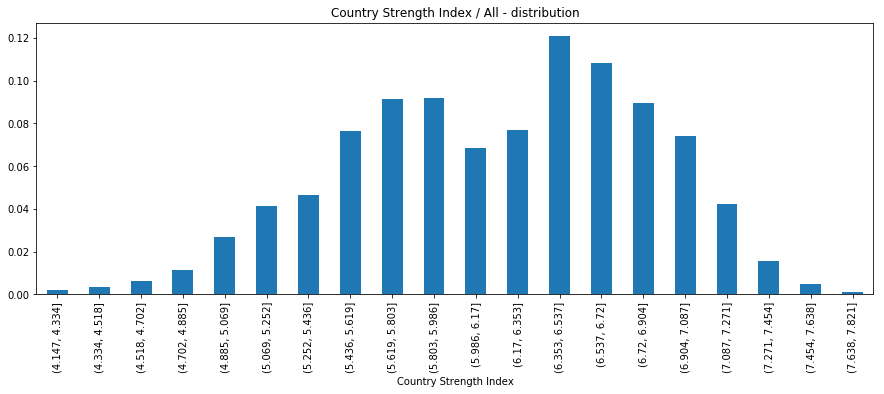

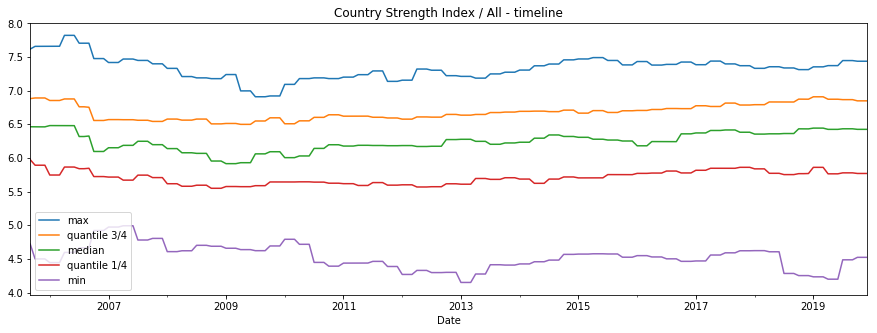

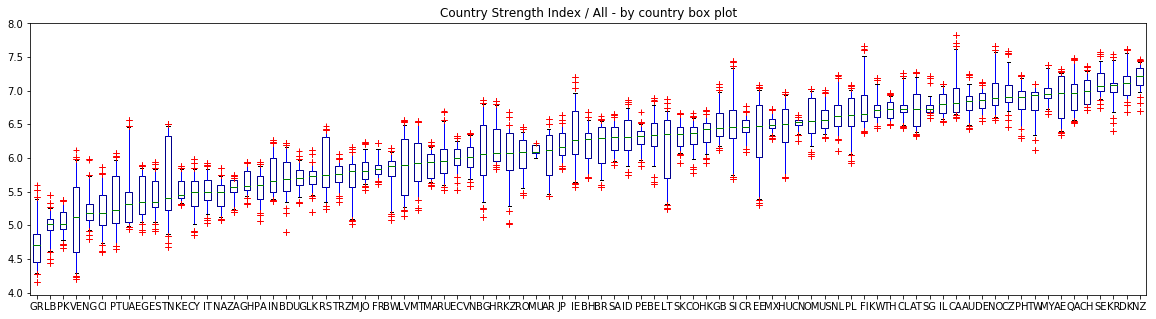

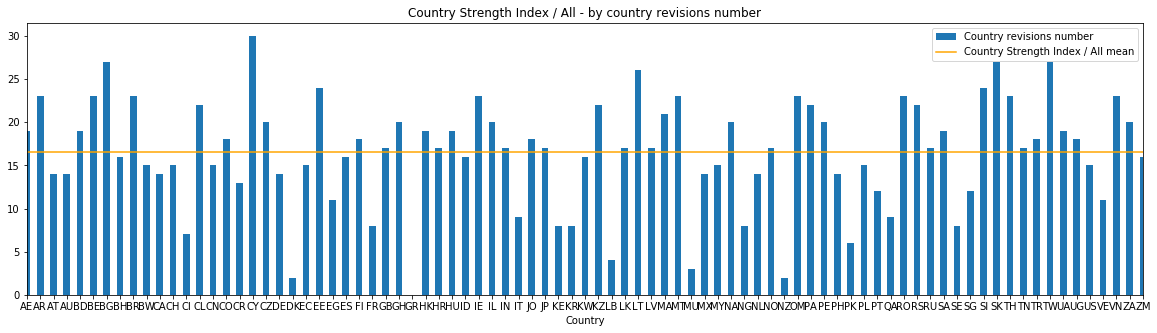

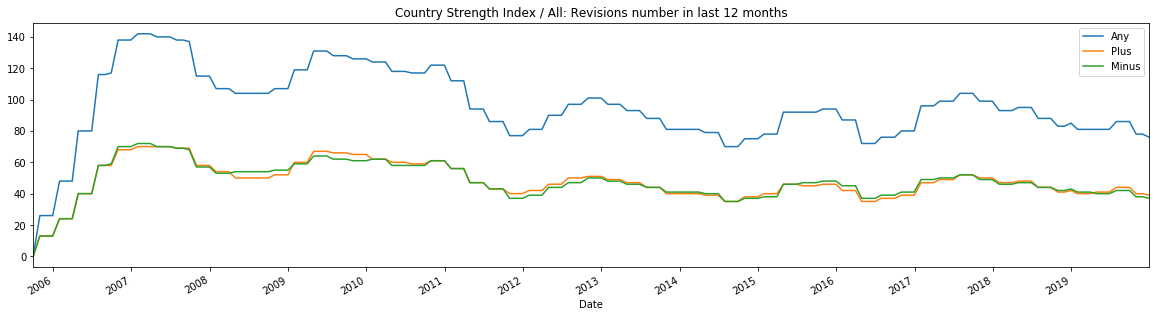

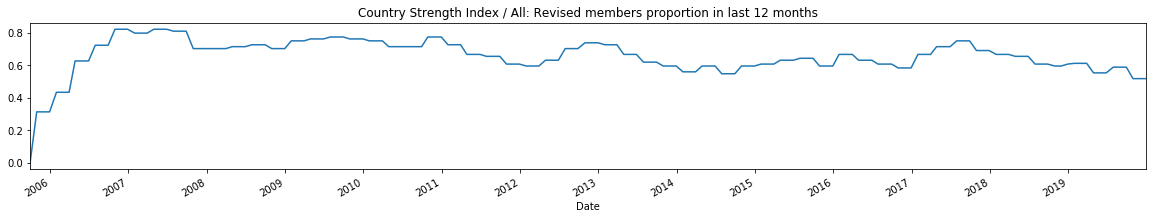

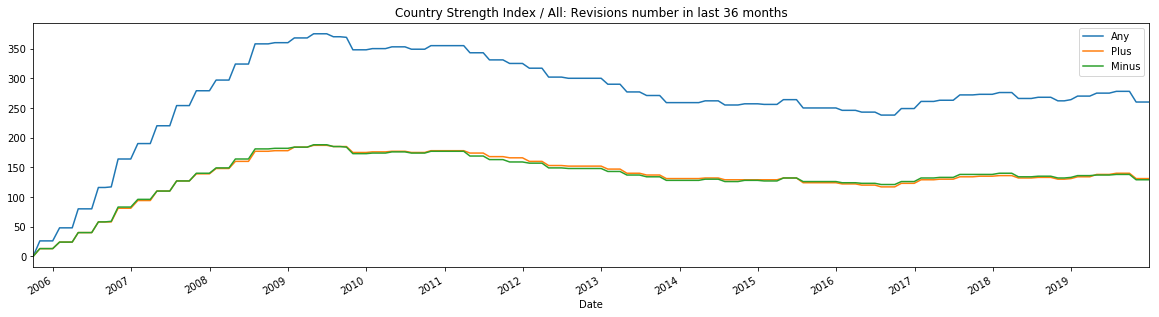

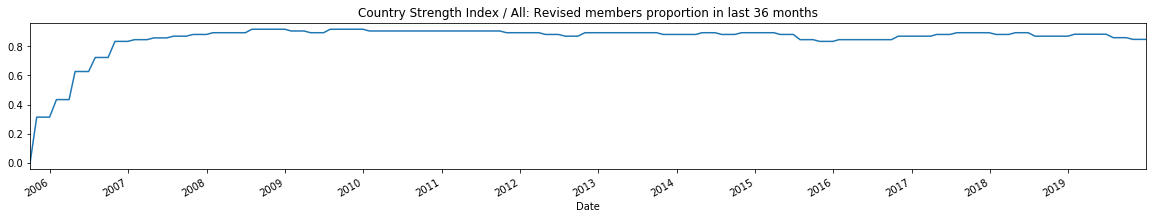

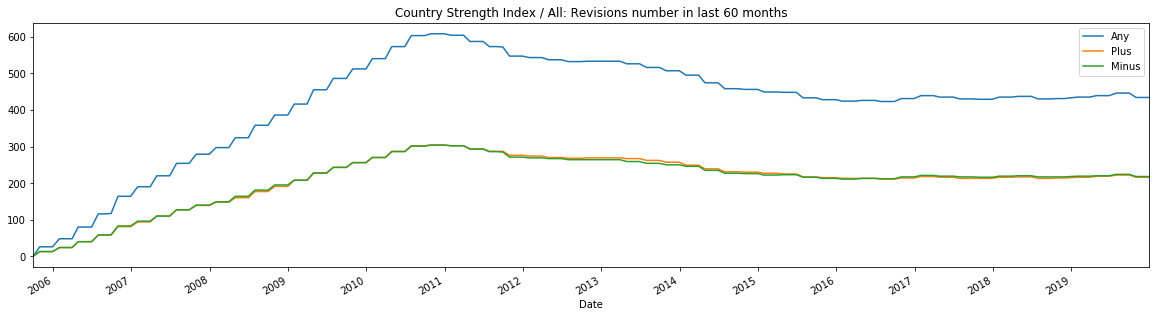

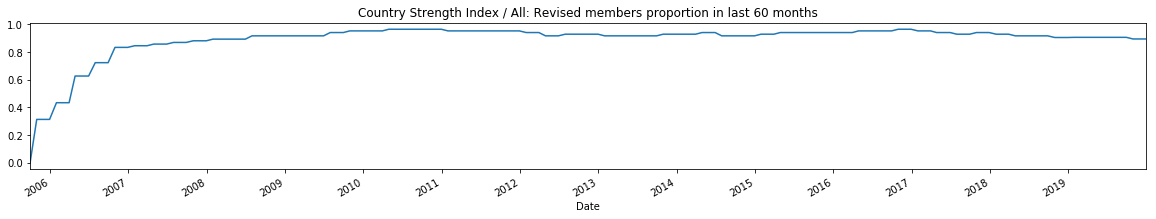

Country Strength Index : All markets ( 14449 ) : Countries covered: 85
Country Strength Index : All markets ( 14449 ) : Average observations per country: 169.99
Country Strength Index : All markets ( 14449 ) : Mean coverage per country: 100.00%
Country Strength Index : All markets ( 14449 ) : Any revisions frequency: 9.70% ( 1402 )
Country Strength Index : All markets ( 14449 ) : Positive revisions frequency: 4.86% ( 702 )
Country Strength Index : All markets ( 14449 ) : Negative revisions frequency: 4.84% ( 700 )
Country Strength Index : All markets ( 14449 ) : Average revisions number for country: 16.49
Country Strength Index : All markets ( 14449 ) : Average stable rating period lentgh (months): 9.72
Country Strength Index : All markets: Mean revision absolute step: 1.06
Country Strength Index : All markets: Mean revision positive step: 1.06
Country Strength Index : All markets: Mean revision negative step: -1.06
Country Strength Index : All markets: Mean cross-sectional interquanti

In [6]:
### VISUALIZING:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
### Constants for universe filtering:
arr_tup_index = [(All, All, All), (All, All, 'DM'), (All, All, 'EM'), (All, All, 'FM')]
arr_tup_market = ['All', 'DM', 'EM', 'FM']
num_rating_round_level = 2
num_quantile_bins = 10
#arr_tup_index = [(All, All, All), (All, 'DM', All), (All, ['EM', 'FM'], All)]
#arr_tup_market = ['All', 'DM', 'EM & FM']
### Constants for rolling calculations:
arr_roll_max = [12, 36, 60]
### Function for calculating length of constant rating periods:
def rolling_count(iter_delta):
    if (iter_delta == 0):
        rolling_count.iter_counter = rolling_count.iter_counter + 1
        rolling_count.iter_result = 0
    else:
        rolling_count.iter_result = rolling_count.iter_counter
        rolling_count.iter_counter = 1
    return rolling_count.iter_result
rolling_count.iter_counter = 1 
rolling_count.iter_result = 0
### Main loop:
for iter_pillar in df_pillars.columns: ### Agencies iterating
    for iter_num, iter_tup_market in enumerate(arr_tup_index):  ### Universe filters iterating
        ### Grades series defining:
        iter_ser_grades = df_pillars.loc[iter_tup_market, iter_pillar].dropna().sort_index(level = ['Country', 'Date'], ascending = [True, True])        
        ### Counter for country rankings:
        iter_ser_counter = iter_ser_grades.groupby('Country').count()
        ### Deltas series calculation:
        iter_ser_deciles = df_pillars.loc[All, iter_pillar].groupby('Date').transform(lambda iter_group: pd.qcut(iter_group, q = num_quantile_bins, 
                                                                                                                     labels = False, duplicates = 'drop'))        
        iter_ser_deltas = iter_ser_deciles.dropna().groupby('Country').diff().sort_index(level = ['Country', 'Date'], ascending = [True, True])
        ### Rolling revisions number for every date calculation:
        arr_df_roll_flag_date = {}
        arr_df_roll_flag_market = {}    
        arr_df_crosstab = {}        
        for iter_roll_max in arr_roll_max:
            num_roll_max = iter_roll_max
            num_roll_min = 2 # num_roll_max // 2
            iter_ser_flag = iter_ser_deltas.copy()
            iter_ser_flag[iter_ser_flag != 0] = iter_ser_flag / iter_ser_flag.abs()
            iter_ser_flag_plus = iter_ser_flag.copy()
            iter_ser_flag_plus[iter_ser_flag_plus != 1] = 0
            iter_ser_flag_minus = iter_ser_flag.copy()
            iter_ser_flag_minus[iter_ser_flag_minus != -1] = 0
            iter_ser_roll_flag_plus = iter_ser_flag_plus.groupby('Country').rolling(window = num_roll_max, min_periods = num_roll_min).sum()
            iter_ser_roll_flag_plus = iter_ser_roll_flag_plus.reset_index(level = 0, drop = True)
            iter_ser_roll_flag_minus = iter_ser_flag_minus.abs().groupby('Country').rolling(window = num_roll_max, min_periods = num_roll_min).sum()
            iter_ser_roll_flag_minus = iter_ser_roll_flag_minus.reset_index(level = 0, drop = True)
            iter_ser_roll_flag = iter_ser_roll_flag_plus + iter_ser_roll_flag_minus
            iter_df_roll_flag = pd.concat([iter_ser_roll_flag, iter_ser_roll_flag_plus, iter_ser_roll_flag_minus], axis = 1)
            iter_df_roll_flag.sort_index(level = ['Country', 'Date'], ascending = [True, True], inplace = True)  
            iter_df_roll_flag = iter_df_roll_flag.loc[iter_tup_market, All]
            iter_df_roll_flag.columns = ['Any', 'Plus', 'Minus']
            iter_df_roll_flag_date = iter_df_roll_flag.groupby('Date').sum()          
            arr_df_roll_flag_date[num_roll_max] = iter_df_roll_flag_date
            iter_df_roll_flag_market_all = iter_df_roll_flag.groupby('Date')
            iter_df_roll_flag_market_revised = iter_df_roll_flag[iter_df_roll_flag['Any'] > 0].groupby('Date')
            iter_df_roll_flag_market = iter_df_roll_flag_market_revised.count().div(iter_df_roll_flag_market_all.count())['Any']
            iter_df_roll_flag_market.fillna(0, inplace = True)
            arr_df_roll_flag_market[num_roll_max] = iter_df_roll_flag_market            
        ### Constant periods lengths series calculation:
        iter_ser_deltas = iter_ser_deltas.shift(-1)    
        iter_ser_distances = iter_ser_deltas.apply(rolling_count)
        iter_ser_distances = iter_ser_distances.loc[iter_tup_market]
        iter_ser_deltas = iter_ser_deltas.shift()  
        iter_ser_deltas = iter_ser_deltas.loc[iter_tup_market]
        ### Deltas number for countries calculation:        
        iter_ser_deltas_countries = iter_ser_deltas.dropna()[iter_ser_deltas != 0].groupby('Country').count()
        iter_ser_deltas_countries = iter_ser_deltas_countries / iter_ser_deltas.dropna().groupby('Country').count()
        iter_ser_deltas_countries.fillna(0, inplace = True)
        iter_ser_deltas_countries = iter_ser_deltas_countries * iter_ser_deltas.dropna().groupby('Country').count()
        
        iter_ser_deltas_countries.name = 'Country revisions number'
        ### Mean deltas for universe filter:
        iter_ser_deltas_mean = pd.Series(iter_ser_deltas_countries.mean(), index = iter_ser_deltas_countries.index)        
        iter_ser_deltas_mean.name = iter_pillar + ' / ' + arr_tup_market[iter_num] + ' mean'
        ### Filtered universe grades distribution drawing:
        (iter_ser_grades.groupby(pd.cut(iter_ser_grades, 20)).count() / iter_ser_grades.count()).plot(figsize = (15, 5), kind = 'bar', 
                                                                                          title = iter_pillar + ' / ' + arr_tup_market[iter_num] + ' - distribution')
        plt.show()        
        ### Timeline for filtered market time-series aggregating:
        grouper_market_by_country = iter_ser_grades.groupby('Country')
        ### Timeline for filtered market plotting:
        grouper_market_by_date = iter_ser_grades.groupby('Date')
        df_timeline_market = pd.concat([grouper_market_by_date.max(), grouper_market_by_date.quantile(0.75), grouper_market_by_date.median(), 
                                        grouper_market_by_date.quantile(0.25), grouper_market_by_date.min()], axis = 1)
        df_timeline_market.columns = ['max', 'quantile 3/4', 'median', 'quantile 1/4', 'min']
        df_timeline_market.plot(figsize = (15, 5), title = iter_pillar + ' / ' + arr_tup_market[iter_num] + ' - timeline')
        plt.show()        
        ### Timeline for filtered countries plotting:
        dict_color = {'boxes': 'DarkBlue', 'medians': 'Green', 'whiskers': 'Blue', 'caps': 'Black'}
        iter_ser_grades.unstack('Country').reindex(iter_ser_grades.unstack('Country').median().sort_values().index, axis = 1).plot.box(figsize = (20, 5), 
                                                                           title = iter_pillar + ' / ' + arr_tup_market[iter_num] + ' - by country box plot',
                                                                           color = dict_color, sym = 'r+', whis = [10, 90])        
        plt.show()
        ### Revisions number for filtered countries plotting:        
        iter_ser_deltas_countries.plot.bar(figsize = (20, 5), title = iter_pillar + ' / ' + arr_tup_market[iter_num] + ' - by country revisions number',
                                           legend = True, width = 0.5)
        iter_ser_deltas_mean.plot(color = 'Orange', legend = True)
        plt.show()
        for iter_roll_max in arr_roll_max:           
            ### Revisions number by date plotting:
            num_roll_max = iter_roll_max
            iter_df_roll_flag_date = arr_df_roll_flag_date[num_roll_max]
            plot_roll_flag_date = iter_df_roll_flag_date.plot(figsize = (20, 5), x_compat = True)
            plot_roll_flag_date.set_title(iter_pillar + ' / ' +  arr_tup_market[iter_num] + ': Revisions number in last ' + str(num_roll_max) + ' months')
            plot_roll_flag_date.xaxis.set_major_locator(mdates.YearLocator())
            plt.gcf().autofmt_xdate()
            plt.show() 
            
            iter_df_roll_flag_market = arr_df_roll_flag_market[num_roll_max]
            plot_roll_flag_market = iter_df_roll_flag_market.plot(figsize = (20, 3), x_compat = True)
            plot_roll_flag_market.set_title(iter_pillar + ' / ' +  arr_tup_market[iter_num] + ': Revised members proportion in last ' + str(num_roll_max) + ' months')
            plot_roll_flag_market.xaxis.set_major_locator(mdates.YearLocator())    
            plt.gcf().autofmt_xdate()
            plt.show()             
        ### Displaying statistics for filtered universe:
        print(iter_pillar, ':', arr_tup_market[iter_num], 'markets (', iter_ser_grades.count(), ')',
              ': Countries covered:', iter_ser_counter.count())   
        print(iter_pillar, ':', arr_tup_market[iter_num], 'markets (', iter_ser_grades.count(), ')',
              ': Average observations per country:', round(iter_ser_counter.mean(), 2)) 
        print(iter_pillar, ':', arr_tup_market[iter_num], 'markets (', iter_ser_grades.count(), ')',
              ': Mean coverage per country:', '{:.2%}'.format((iter_ser_counter / iter_ser_grades.fillna(0).groupby('Country').count()).mean()))
        print(iter_pillar, ':', arr_tup_market[iter_num], 'markets (', iter_ser_grades.count(), ')',
              ': Any revisions frequency:', '{:.2%}'.format(len(iter_ser_deltas.dropna()[iter_ser_deltas != 0].index) / iter_ser_grades.count()), 
              '(', len(iter_ser_deltas.dropna()[iter_ser_deltas != 0].index), ')')
        print(iter_pillar, ':', arr_tup_market[iter_num], 'markets (', iter_ser_grades.count(), ')',
              ': Positive revisions frequency:', '{:.2%}'.format(len(iter_ser_deltas[iter_ser_deltas > 0].index) / iter_ser_grades.count()), 
              '(', len(iter_ser_deltas[iter_ser_deltas > 0].index), ')')  
        print(iter_pillar, ':', arr_tup_market[iter_num], 'markets (', iter_ser_grades.count(), ')',
              ': Negative revisions frequency:', '{:.2%}'.format(len(iter_ser_deltas[iter_ser_deltas < 0].index) / iter_ser_grades.count()), 
              '(', len(iter_ser_deltas[iter_ser_deltas < 0].index), ')')
        print(iter_pillar, ':', arr_tup_market[iter_num], 'markets (', iter_ser_grades.count(), ')',
              ': Average revisions number for country:', round(iter_ser_deltas_countries.mean(), 2))        
        print(iter_pillar, ':', arr_tup_market[iter_num], 'markets (', iter_ser_grades.count(), ')',
              ': Average stable rating period lentgh (months):', 
              round(iter_ser_distances[iter_ser_distances > 0].mean(), 2)) 
        print(iter_pillar, ':', arr_tup_market[iter_num], 'markets: Mean revision absolute step:', 
              round(iter_ser_deltas.abs()[iter_ser_deltas != 0].mean(), 2))   
        print(iter_pillar, ':', arr_tup_market[iter_num], 'markets: Mean revision positive step:', 
              round(iter_ser_deltas[iter_ser_deltas > 0].mean(), 2))
        print(iter_pillar, ':', arr_tup_market[iter_num], 'markets: Mean revision negative step:', 
              round(iter_ser_deltas[iter_ser_deltas < 0].mean(), 2))
        print(iter_pillar, ':', arr_tup_market[iter_num], 'markets: Mean cross-sectional interquantile range (between 0.9 and 0.1 quantile):', 
              round((grouper_market_by_date.quantile(0.90) - grouper_market_by_date.quantile(0.10)).mean(), 2))
        print(iter_pillar, ':', arr_tup_market[iter_num], 'markets: Mean cross-sectional median:', 
              round(grouper_market_by_date.median().mean(), 2))       
        print(iter_pillar, ':', arr_tup_market[iter_num], 'markets: Mean country interquantile range (between 0.9 and 0.1 quantile):', 
              round((grouper_market_by_country.quantile(0.90) - grouper_market_by_country.quantile(0.10)).mean(), 2))
        print(iter_pillar, ':', arr_tup_market[iter_num], 'markets: Median country interquantile range (between 0.9 and 0.1 quantile):', 
              round((grouper_market_by_country.quantile(0.90) - grouper_market_by_country.quantile(0.10)).median(), 2))       
        print(iter_pillar, ':', arr_tup_market[iter_num], 'markets:  Mean absolute deviation for countries mean:', 
              round(grouper_market_by_country.mad().mean(), 2))         
        print(iter_pillar, ':', arr_tup_market[iter_num], 'markets:  Mean absolute deviation for countries median:', 
              round(grouper_market_by_country.mad().median(), 2))        
        for iter_roll_max in arr_roll_max:
            num_roll_max = iter_roll_max
            iter_df_roll_flag_date = arr_df_roll_flag_date[num_roll_max]
            iter_df_roll_flag_market = arr_df_roll_flag_market[num_roll_max]
            print(iter_pillar, ':', arr_tup_market[iter_num], 'markets (', len(iter_df_roll_flag_date.index), 'datepoints)',
                  ': Datepoints with at least one revision in last', num_roll_max,'months:', 
                  '{:.2%}'.format(len(iter_df_roll_flag_date[iter_df_roll_flag_date['Any'] > 0].index) / len(iter_df_roll_flag_date.index)), 
                  '(', len(iter_df_roll_flag_date[iter_df_roll_flag_date['Any'] > 0].index), ')')
            print(iter_pillar, ':', arr_tup_market[iter_num], 'markets (', len(iter_df_roll_flag_date.index), 'datepoints)',
                  ': Datepoints with no revisions in last', num_roll_max,'months:', 
                  '{:.2%}'.format(len(iter_df_roll_flag_date[iter_df_roll_flag_date['Any'] == 0].index) / len(iter_df_roll_flag_date.index)), 
                  '(', len(iter_df_roll_flag_date[iter_df_roll_flag_date['Any'] == 0].index), ')')
            print(iter_pillar, ':', arr_tup_market[iter_num], 'markets: Mean any revisions number in last', num_roll_max,'months from datepoint:',
                  round(iter_df_roll_flag_date['Any'].mean(), 2)) 
            print(iter_pillar, ':', arr_tup_market[iter_num], 'markets: Mean positive revisions number in last', num_roll_max,'months from datepoint:',
                  round(iter_df_roll_flag_date['Plus'].mean(), 2)) 
            print(iter_pillar, ':', arr_tup_market[iter_num], 'markets: Mean negative revisions number in last', num_roll_max,'months from datepoint:',
                  round(iter_df_roll_flag_date['Minus'].mean(), 2))   
            print(iter_pillar, ':', arr_tup_market[iter_num], 'markets: Mean proportion of members revised in last', num_roll_max,'months from market:',
                  '{:.2%}'.format(round(iter_df_roll_flag_market.mean(), 4)))         

#        if (iter_num == 1):
#            break
        break        
#    if (iter_risk == 'FITCH'):
#        break
    break

In [24]:
### TEMP

pd.cut(iter_ser_grades, 20)
#iter_ser_grades.groupby(pd.cut(iter_ser_grades.round(), 20))


(Date        Country  Market
 2005-09-30  AE       NaN       (6.8, 7.0]
 2005-10-31  AE       NaN       (6.8, 7.0]
 2005-11-30  AE       NaN       (6.8, 7.0]
 2005-12-30  AE       NaN       (6.8, 7.0]
 2006-01-31  AE       NaN       (5.8, 6.0]
                                   ...    
 2019-08-30  ZM       FM        (4.8, 5.0]
 2019-09-30  ZM       FM        (4.8, 5.0]
 2019-10-31  ZM       FM        (4.8, 5.0]
 2019-11-29  ZM       FM        (4.8, 5.0]
 2019-12-31  ZM       FM        (4.8, 5.0]
 Name: Country Strength Index, Length: 14449, dtype: category
 Categories (20, interval[float64]): [(3.996, 4.2] < (4.2, 4.4] < (4.4, 4.6] < (4.6, 4.8] ... (7.2, 7.4] < (7.4, 7.6] < (7.6, 7.8] < (7.8, 8.0]],
 array([3.996, 4.2  , 4.4  , 4.6  , 4.8  , 5.   , 5.2  , 5.4  , 5.6  ,
        5.8  , 6.   , 6.2  , 6.4  , 6.6  , 6.8  , 7.   , 7.2  , 7.4  ,
        7.6  , 7.8  , 8.   ]))

In [20]:
### TEMP

iter_ser_grades[(iter_ser_grades < 6.8) & (iter_ser_grades > 6.2)]

Date        Country  Market
2005-09-30  AE       NaN       6.720280
2005-10-31  AE       NaN       6.558186
2005-11-30  AE       NaN       6.558186
2005-12-30  AE       NaN       6.558186
2006-01-31  AE       NaN       6.489271
                                 ...   
2019-08-30  VN       FM        6.294929
2019-09-30  VN       FM        6.294929
2019-10-31  VN       FM        6.267763
2019-11-29  VN       FM        6.267763
2019-12-31  VN       FM        6.267763
Name: Country Strength Index, Length: 4806, dtype: float64